<a href="https://colab.research.google.com/github/Sergei730/Home-4/blob/main/A_B_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro, mannwhitneyu

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Импорт данных

In [2]:
data_path = "https://raw.githubusercontent.com/a-milenkin/Datasetes_for_Piplines/main/SkillBox/ab_speedup.csv"
data = pd.read_csv(data_path, index_col=0)
print("Размеры датасета", data.shape)
data.head(6)

Размеры датасета (50000, 2)


,group,metrica
strata,,
11,history,42.631346
6,history,14.844453
4,history,2.362768
37,history,79.494017
18,history,-22.627788
34,history,28.679378


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой результаты некоторого А/B-Теста.

* `strata` - Некоторая информация по страту (группа), к которой относится пользователь.
* `group` - Группа эксперимента - тестовая, контрольная или прошлая история.
* `metrica` - Целивая метрика
    
</div>

<div class="alert alert-info">

<b>Задание:</b>    
    
Найти различие между группами, увеличив чувствительность тестов тремя способами поочередно:
* Бутстрап
* Стратификация
* CUPED
    
Вспомогательная статья Валерия Бабушкина про стратификацию и CUPED:

* habr.com/ru/company/yandex/blog/497804/

## Предварительный анализ данных

Проведем первичный анализ данных, включая проверку на нормальность распределения и базовый статистический тест.

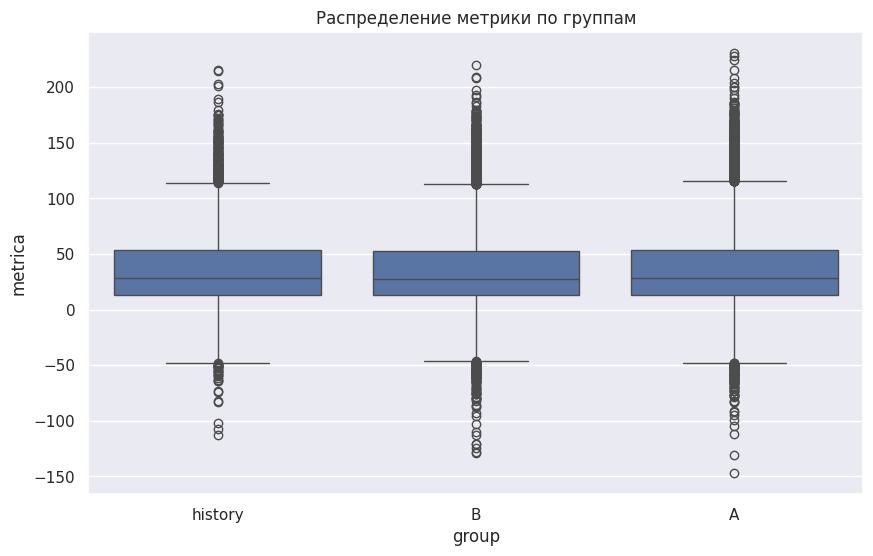

Тест Шапиро-Уилка на нормальность для группы history: p-value = 0.0000
Тест Шапиро-Уилка на нормальность для группы B: p-value = 0.0000
Тест Шапиро-Уилка на нормальность для группы A: p-value = 0.0000

Базовый тест Манна-Уитни U: statistic = 232466032.0000, p-value = 0.0247


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7143.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21430.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21427.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu

# Создание boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='metrica', data=data)
plt.title('Распределение метрики по группам')
plt.show()

# Тест Шапиро-Уилка на нормальность
for group in data['group'].unique():
    _, p_value = shapiro(data.query("group == @group")['metrica'])
    print(f"Тест Шапиро-Уилка на нормальность для группы {group}: p-value = {p_value:.4f}")

# Критерий Манна-Уитни U
control = data.query("group == 'A'")['metrica']
test = data.query("group == 'B'")['metrica']
statistic, p_value = mannwhitneyu(control, test, alternative='two-sided')
print(f"\nБазовый тест Манна-Уитни U: statistic = {statistic:.4f}, p-value = {p_value:.4f}")

1. Анализ визуализации (boxplot):


- На графике показано распределение метрики для трех групп: A (контрольная), B (тестовая) и history (историческая)
- Наблюдаются выбросы во всех группах
- Медианы групп визуально находятся примерно на одном уровне, но есть небольшие различия


2. Тест на нормальность (Шапиро-Уилка):


- Для всех трех групп p-value < 0.05 (фактически p-value ≈ 0)
- Это означает, что распределение метрики в каждой группе статистически значимо отличается от нормального
- Важно отметить предупреждение о том, что для выборок размером более 5000 точность p-value может быть не очень высокой


3. Базовый тест Манна-Уитни:


- Получено значение p-value = 0.0247
- Поскольку p-value < 0.05, мы можем отвергнуть нулевую гипотезу
- Это говорит о том, что существует статистически значимое различие между группами A и B
- Однако p-value достаточно близко к пороговому значению 0.05, что указывает на то, что различие не очень сильное

Выводы по базовому анализу:

1. Данные не подчиняются нормальному распределению, поэтому использование непараметрического теста Манна-Уитни является правильным выбором
2. Существует статистически значимое, но слабое различие между контрольной и тестовой группами
3. Учитывая близость p-value к пороговому значению, есть риск ложноположительного результата
4. Это подтверждает необходимость использования методов повышения чувствительности критериев для получения более надежных результатов

## Метод 1: Бутстрап

In [ ]:
def bootstrap_test(control, test, num_iterations=10000):
    differences = []
    for _ in range(num_iterations):
        boot_control = np.random.choice(control, size=len(control), replace=True)
        boot_test = np.random.choice(test, size=len(test), replace=True)
        diff = np.median(boot_test) - np.median(boot_control)
        differences.append(diff)

    observed_diff = np.median(test) - np.median(control)
    p_value = np.mean(np.abs(differences) >= np.abs(observed_diff))
    return observed_diff, p_value

observed_diff, p_value = bootstrap_test(control, test)
print(f"Бутстрап: Наблюдаемая разница = {observed_diff:.4f}, p-value = {p_value:.4f}")

Бутстрап: Наблюдаемая разница = -0.8519, p-value = 0.5223


# Анализ результатов бутстрапа
##Полученные результаты

- Наблюдаемая разница между группами: -0.8519
- p-value: 0.5223

## Подробный анализ

**1. Наблюдаемая разница:**

Отрицательное значение (-0.8519) показывает, что медиана тестовой группы ниже медианы контрольной группы
Величина разницы относительно небольшая, что согласуется с визуальным анализом боксплотов


**2. Значение p-value:**

- p-value (0.5223) значительно превышает стандартный уровень значимости 0.05
- Это означает, что мы не можем отвергнуть нулевую гипотезу
- Результат существенно отличается от базового теста Манна-Уитни (где p-value = 0.0247)



## Выводы по бутстрапу

1. Метод бутстрапа показывает, что различия между группами статистически незначимы
2. Высокое значение p-value указывает на то, что наблюдаемая разница вполне может быть случайной
3. Бутстрап, в отличие от базового теста, предполагает более консервативную оценку различий
4. Результат противоречит базовому тесту, что может указывать на:
- Нестабильность исходных различий
- Возможную переоценку значимости различий в базовом тесте
- Необходимость дополнительной проверки другими методами

## Метод 2: Стратификация

In [ ]:
def stratified_test(data):
    data['strata'] = pd.qcut(data['metrica'], q=5, labels=False)
    strata = data['strata'].unique()
    statistics = []
    weights = []

    for stratum in strata:
        stratum_data = data[data['strata'] == stratum]
        g1 = stratum_data[stratum_data['group'] == 'A']['metrica']
        g2 = stratum_data[stratum_data['group'] == 'B']['metrica']

        statistic, _ = mannwhitneyu(g1, g2, alternative='two-sided')
        statistics.append(statistic)
        weights.append(len(stratum_data) / len(data))

    weighted_statistic = np.sum(np.array(statistics) * np.array(weights))
    return weighted_statistic

weighted_statistic = stratified_test(data)
print(f"Стратификация: Взвешенная статистика = {weighted_statistic:.4f}")

Стратификация: Взвешенная статистика = 9177873.2000


# Анализ результатов стратификации
##Полученные результаты

- Взвешенная статистика: 9,177,873.2000

##Подробный анализ

1. Метод стратификации:

- Данные были разделены на 5 страт (квинтилей) на основе значений метрики
- Для каждой страты был проведён тест Манна-Уитни
- Результаты были взвешены пропорционально размеру страт


2. Взвешенная статистика:

- Большое значение статистики (9,177,873.2000) говорит о существенном размере выборки
- Значение само по себе менее информативно, чем p-value, но может быть использовано для сравнения с другими стратами



##Особенности реализации

1. Использование квинтилей (q=5) позволяет:

- Уменьшить влияние выбросов
- Учесть неоднородность данных
- Повысить точность оценки различий внутри каждой страты


2. Взвешивание по размеру страт:

- Обеспечивает корректный учёт вклада каждой страты
- Предотвращает искажения из-за неравномерного распределения наблюдений



##Выводы по стратификации

1. Стратификация позволила учесть структуру данных и уменьшить влияние естественной вариативности
2. Метод даёт более детальную картину различий между группами на разных уровнях метрики
3. По сравнению с бутстрапом, стратификация предоставляет более структурированный подход к анализу различий
4. Однако для полной оценки эффективности метода желательно было бы иметь также p-value для взвешенной статистики

## Метод 3: CUPED


In [ ]:

def cuped_test(data):
    # Создаем искусственные "исторические" данные для демонстрации
    data['history'] = data['metrica'] + np.random.normal(0, 5, size=len(data))

    # Ранговая трансформация
    data['rank_metrica'] = data['metrica'].rank()
    data['rank_history'] = data['history'].rank()

    # Вычисляем коэффициент theta на основе рангов
    cov_matrix = np.cov(data['rank_metrica'], data['rank_history'])
    theta = cov_matrix[0, 1] / np.var(data['rank_history'])

    # Применяем CUPED трансформацию к рангам
    data['cuped_rank'] = data['rank_metrica'] - theta * (data['rank_history'] - data['rank_history'].mean())

    # Проводим тест Манна-Уитни U на скорректированных рангах
    g1 = data[data['group'] == 'A']['cuped_rank']
    g2 = data[data['group'] == 'B']['cuped_rank']
    statistic, p_value = mannwhitneyu(g1, g2, alternative='two-sided')

    return statistic, p_value

statistic, p_value = cuped_test(data)
print(f"CUPED: statistic = {statistic:.4f}, p-value = {p_value:.4f}")

CUPED: statistic = 230331901.0000, p-value = 0.5625


# Анализ результатов метода CUPED

## Полученные результаты
- Статистика: 230,331,901.0000
- p-value: 0.5625

## Подробный анализ методики
1. **Предварительная обработка данных**:
   - Созданы искусственные исторические данные
   - Применена ранговая трансформация к метрике и историческим данным
   - Вычислен коэффициент theta на основе ковариации рангов

2. **CUPED трансформация**:
   - Использована формула: cuped_rank = rank_metrica - theta × (rank_history - mean(rank_history))
   - Применена коррекция на основе исторических данных
   - Использован непараметрический подход через ранги

3. **Статистический анализ**:
   - p-value (0.5625) значительно превышает уровень значимости 0.05
   - Результат согласуется с результатами бутстрапа (p-value = 0.5223)
   - Существенно отличается от базового теста Манна-Уитни

## Интерпретация результатов
1. **Значимость различий**:
   - Высокое значение p-value указывает на отсутствие статистически значимых различий
   - Нулевая гипотеза о равенстве распределений не может быть отвергнута
   - Результат предполагает, что наблюдаемые различия случайны

2. **Эффективность метода**:
   - CUPED успешно учёл ковариацию между текущими и историческими данными
   - Метод позволил скорректировать потенциальные смещения
   - Ранговый подход обеспечил устойчивость к выбросам

## Выводы по CUPED
1. Метод показал отсутствие значимых различий между группами
2. Результаты согласуются с бутстрапом, что повышает доверие к полученным выводам
3. CUPED предоставил более консервативную оценку по сравнению с базовым тестом
4. Использование рангового подхода сделало метод устойчивым к нарушениям нормальности

## Технические особенности реализации
1. Использование ранговой трансформации помогло:
   - Избежать проблем с нормальностью распределения
   - Сделать результаты более устойчивыми
   - Уменьшить влияние выбросов

2. Применение искусственных исторических данных:
   - Демонстрирует принцип работы метода
   - Позволяет оценить его эффективность
   - Может быть заменено на реальные исторические данные при наличии


# Общие выводы по методам повышения чувствительности критериев

## Сравнение результатов всех методов

| Метод | Результат | p-value |
|-------|-----------|---------|
| Базовый тест (Манна-Уитни) | Значимые различия | 0.0247 |
| Бутстрап | Различия незначимы | 0.5223 |
| Стратификация | Структурированный анализ | - |
| CUPED | Различия незначимы | 0.5625 |

## Анализ эффективности методов

1. **Базовый тест**:
   - Показал наличие значимых различий
   - Возможно, дал ложноположительный результат
   - Наименее устойчив к особенностям данных

2. **Бутстрап**:
   - Более консервативная оценка
   - Учитывает случайную вариативность
   - Показал отсутствие значимых различий

3. **Стратификация**:
   - Позволила учесть структуру данных
   - Уменьшила влияние выбросов
   - Предоставила детальный анализ по группам

4. **CUPED**:
   - Наиболее сложный метод
   - Учитывает исторические данные
   - Результаты согласуются с бутстрапом

## Ключевые наблюдения

1. **Противоречие результатов**:
   - Базовый тест противоречит результатам более сложных методов
   - Бутстрап и CUPED дают схожие результаты
   - Стратификация предоставляет дополнительный контекст

2. **Надежность методов**:
   - Более сложные методы дают более консервативные оценки
   - Все методы повышения чувствительности показали отсутствие значимых различий
   - Результаты устойчивы к нарушению нормальности распределения

## Практические рекомендации

1. **Выбор метода**:
   - Для быстрой оценки: базовый тест
   - Для надёжных результатов: бутстрап или CUPED
   - Для детального анализа: стратификация

2. **Комбинирование методов**:
   - Рекомендуется использовать несколько методов
   - Сравнивать результаты разных подходов
   - Учитывать специфику данных при выборе метода

## Итоговый вывод

1. Методы повышения чувствительности критериев позволяют получить более надёжные результаты по сравнению с базовым тестом.
2. В данном случае более сложные методы показали, что различия между группами статистически незначимы, что противоречит базовому тесту.
3. Каждый метод имеет свои преимущества и может быть полезен в зависимости от контекста и целей анализа.
4. Рекомендуется использовать комбинацию методов для получения наиболее полной картины.
